2. [Machine learning](#Machine-learning)
3. [model interpitation](#model-interpitation)

дата сет посвящен задачи оттока клиетов, когда клиенту уходят от услуг компании

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# анализ данных

In [3]:
len(df) # размер датафрейма

10000

In [4]:
df.isna().mean() # смотрю есть ли пропуски

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

    Exited - целевая переменная. там 0 и 1

In [5]:
df['Exited'].value_counts(normalize=True) # покажет в процентах

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [6]:
df['Exited'].mean()

0.2037

    Сделаем сначала человеческое обучение, что бы потом сравнить его  с машинным
    
    для начала надо разбить данные на выборки, что если доля тех кто в Exited в тренировочной выборке будет отличаться?. что бы от этого защититься в train_test_split есть опция stratufy, туда передаю то по какому столбцу буду  делать стратификацию, что бы эта доля была равна
    
    это надо обязательно делать когда у нас мало данных. когда данных много, все будет стратифицироваться само, автоматически

In [7]:
from sklearn.model_selection import train_test_split

# создаю выборки, тренировочную, тестовую и валидационную
train, test = train_test_split(df, train_size=0.6, random_state=42, stratify=df['Exited'])
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['Exited'])

len(train) + len(val) + len(test), [len(train), len(val), len(test)], len(df)

(10000, [6000, 2000, 2000], 10000)

In [8]:
train['Exited'].mean()

0.20366666666666666

In [9]:
val['Exited'].mean()

0.204

In [10]:
test['Exited'].mean()

0.2035

# Phik

    отобрать наиболее важные переменные по мнению phik.

In [11]:
train_full = pd.concat([train, val])

In [12]:
# ! pip install phik


In [13]:
import phik

phik_overview = train_full.phik_matrix()

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


/home/alekspy/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2591. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


In [14]:
# и так увидим какие переменные наиболее связаны с Exited
phik_overview['Exited'].sort_values(ascending=False)

Exited             1.000000
NumOfProducts      0.564969
Age                0.498241
IsActiveMember     0.237244
Balance            0.167823
Gender             0.165231
CreditScore        0.123343
Geography          0.104047
CustomerId         0.035798
Tenure             0.033611
RowNumber          0.000000
Surname            0.000000
HasCrCard          0.000000
EstimatedSalary    0.000000
Name: Exited, dtype: float64

# human learning

    видно что доля клиентов которые ушли, сильно отличается в зависимости от количества продуктов у них
    эта переменная может быть индикатором того что клиент может уйти
    
    конечная цель определить 0 или 1 (уйдет или нет)
    и что бы это сделать, нужно оценить склонность клиента к оттоку
    и видно что те клиенты у которых 1 продукт, склонность к оттоку 0.27
    у которых 2 продукты 0.07
    и почему то у которых 3 продукта 0.82
    итд

In [15]:
train_full.groupby('NumOfProducts')['Exited'].agg(['count', 'mean'])

,count,mean
NumOfProducts,,
1,4060,0.275369
2,3673,0.077049
3,219,0.826484
4,48,1.000000


In [16]:
model = train_full.groupby('NumOfProducts')['Exited'].mean().reset_index()
model = model.rename({"Exited": "score_prod"}, axis=1) # переимменовываю, для джойна

In [17]:
train_full = train_full.merge(model, how='left', on='NumOfProducts')
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,0.077049
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,0.077049
2,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0,0.077049
3,9059,15802560,Moran,470,Spain,Female,48,6,140576.11,1,1,1,116971.05,0,0.275369
4,9416,15750407,Hunt,768,Germany,Female,43,2,129264.05,2,0,0,19150.14,0,0.077049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,927,15628303,Thurgood,738,Spain,Male,35,3,0.00,1,1,1,15650.73,0,0.275369
7996,6728,15610416,Christie,745,France,Female,36,9,0.00,1,1,0,19605.18,1,0.275369
7997,4746,15655410,Hinton,768,Germany,Male,49,1,133384.66,1,1,0,102397.22,1,0.275369
7998,1308,15638806,Blackburn,645,Spain,Male,49,2,0.00,2,0,0,10023.15,0,0.077049


    а как мы получим 1?... можно сделать отсечение, типа если score больше 0.5, то получаю 1 а если меньше то 0

# baseline

    точка  от которой будем отталкиваться. Пока это будет среднее.
    и так же запишу это  в датафрейм.
    score_mean получается в нашем случае 20 процентов что клиент оттечет mena()
    score_prod уже более осмыслена, она основана на переменной NumOfProducts
    
    в регресии была метрика RMSE
    здесь(в задаче классификации) будет log_lose

In [18]:
train_full['score_mean'] = train_full['Exited'].mean()

In [19]:
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,0.077049,0.20375
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,0.077049,0.20375
2,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0,0.077049,0.20375
3,9059,15802560,Moran,470,Spain,Female,48,6,140576.11,1,1,1,116971.05,0,0.275369,0.20375
4,9416,15750407,Hunt,768,Germany,Female,43,2,129264.05,2,0,0,19150.14,0,0.077049,0.20375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,927,15628303,Thurgood,738,Spain,Male,35,3,0.00,1,1,1,15650.73,0,0.275369,0.20375
7996,6728,15610416,Christie,745,France,Female,36,9,0.00,1,1,0,19605.18,1,0.275369,0.20375
7997,4746,15655410,Hinton,768,Germany,Male,49,1,133384.66,1,1,0,102397.22,1,0.275369,0.20375
7998,1308,15638806,Blackburn,645,Spain,Male,49,2,0.00,2,0,0,10023.15,0,0.077049,0.20375


In [20]:
# эта метрика чаще используется для оптимизации и редко используется для анализа
from sklearn.metrics import log_loss

In [21]:
# сейчас поймем, что скор который сделан на основе продукта, лучше чем тот который сделан на основе среднего

log_loss(train_full['Exited'], train_full['score_mean']) # теперь нужно получать ошибку которая меньше чем это число

0.5055572860042145

In [22]:
log_loss(train_full['Exited'], train_full['score_prod'])  # видно что меньше. значит лучше чем baseline

0.4359616823203511

# Uplift
    интуитивная метрика
    Uplift в машинном обучении — это метрика, которая измеряет, насколько модель улучшила точность своих предсказаний по сравнению с некоторой базовой линией (например, случайной моделью или предыдущей моделью). То есть, если модель демонстрирует uplift, это означает, что она приносит добавочную ценность и работает лучше, чем если бы предсказания были сделаны случайным образом или с помощью какой-то простой модели.

In [23]:
# переменная Exited оттек клиент или нет. и есть скор, чем он больше, тем больше склонность к оттоку
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,0.077049,0.20375
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,0.077049,0.20375
2,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0,0.077049,0.20375
3,9059,15802560,Moran,470,Spain,Female,48,6,140576.11,1,1,1,116971.05,0,0.275369,0.20375
4,9416,15750407,Hunt,768,Germany,Female,43,2,129264.05,2,0,0,19150.14,0,0.077049,0.20375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,927,15628303,Thurgood,738,Spain,Male,35,3,0.00,1,1,1,15650.73,0,0.275369,0.20375
7996,6728,15610416,Christie,745,France,Female,36,9,0.00,1,1,0,19605.18,1,0.275369,0.20375
7997,4746,15655410,Hinton,768,Germany,Male,49,1,133384.66,1,1,0,102397.22,1,0.275369,0.20375
7998,1308,15638806,Blackburn,645,Spain,Male,49,2,0.00,2,0,0,10023.15,0,0.077049,0.20375


In [24]:
# беру случайных 20 процентов
train_full['Exited'].sample(frac=0.2, random_state=42).mean()

0.210625

In [25]:
exited_all = train_full['Exited'].sum()
exited_all

1630

In [26]:
train_full['Exited'].sample(frac=0.2, random_state=42).sum()

337

In [27]:
train_full['Exited'].sample(frac=0.2, random_state=42).sum() / exited_all

0.2067484662576687

In [28]:
train_full = train_full.sort_values('score_prod', ascending=False)
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean
6946,6876,15665283,Brookes,610,France,Female,57,7,72092.95,4,0,1,113228.82,1,1.000000,0.20375
1245,3153,15724161,Sutton,644,France,Female,40,9,137285.26,4,1,0,77063.63,1,1.000000,0.20375
7056,2542,15679770,Smith,611,France,Female,61,3,131583.59,4,0,1,66238.23,1,1.000000,0.20375
7847,1702,15605279,Francis,792,France,Male,50,9,0.00,4,1,1,194700.81,1,1.000000,0.20375
693,7568,15750545,Chidiebere,629,France,Male,44,5,0.00,4,0,0,117572.59,1,1.000000,0.20375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,7543,15768777,Wang,507,Spain,Female,34,4,0.00,2,1,1,60688.38,0,0.077049,0.20375
4912,4011,15685654,Allan,514,Spain,Male,66,9,0.00,2,1,1,14234.31,0,0.077049,0.20375
4913,4872,15575858,Bergamaschi,763,France,Male,40,3,0.00,2,1,0,134281.11,0,0.077049,0.20375
4914,1650,15569423,Cunningham,731,Spain,Male,41,4,0.00,2,1,0,22299.27,0,0.077049,0.20375


In [29]:
round(len(train_full) * 0.2)

1600

In [30]:
# топ 20 процентов отобранных по скор
train_full.head(round(len(train_full) * 0.2))


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean
6946,6876,15665283,Brookes,610,France,Female,57,7,72092.95,4,0,1,113228.82,1,1.000000,0.20375
1245,3153,15724161,Sutton,644,France,Female,40,9,137285.26,4,1,0,77063.63,1,1.000000,0.20375
7056,2542,15679770,Smith,611,France,Female,61,3,131583.59,4,0,1,66238.23,1,1.000000,0.20375
7847,1702,15605279,Francis,792,France,Male,50,9,0.00,4,1,1,194700.81,1,1.000000,0.20375
693,7568,15750545,Chidiebere,629,France,Male,44,5,0.00,4,0,0,117572.59,1,1.000000,0.20375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,1590,15617518,Hu,675,Germany,Male,36,7,89409.95,1,1,1,149399.70,0,0.275369,0.20375
7270,3716,15640409,Carpenter,817,Germany,Female,46,0,89087.89,1,0,1,87941.85,1,0.275369,0.20375
7287,2707,15595071,Ramos,696,France,Male,22,9,149777.00,1,1,1,198032.93,0,0.275369,0.20375
7283,9183,15665579,Cartwright,597,France,Female,28,0,142705.95,1,1,0,127233.39,0,0.275369,0.20375


In [31]:
train_full.head(round(len(train_full) * 0.2))['Exited'].sum() / exited_all


0.3576687116564417

In [32]:
# uplift можно посчитать вот так. И видно как превосходдим baseline
0.3576687116564417 / 0.2067484662576687

1.7299703264094954

# добавить шум. 
    так как текущие скор не уникальные. там по умолчанию  всего 4 уникальных скор.
    и при сортировки, может быть не совсем правильный порядок
    что бы был фиксированный случайный порядок сортировки. и я сделаю эти скоры уникальными. добавлю совсем 
    маеленькое случайное число

In [33]:
import numpy as np


In [34]:
len(np.random.uniform(0, 0.01, size=len(train_full)))

8000

In [35]:
# 8000 чисел в диапазоне от 0 до 0.01
np.random.seed(42) # фиксирую рандом.(надо делать в каждой ячейке)
np.random.uniform(0, 0.001, size=len(train_full)) 

array([0.00037454, 0.00095071, 0.00073199, ..., 0.00045533, 0.00090844,
       0.00010448])

In [36]:
np.random.seed(42) # фиксирую рандом.(надо делать в каждой ячейке)

train_full['score_prod'] = train_full['score_prod'] - np.random.uniform(0, 0.001, size=len(train_full)) 

In [37]:
train_full['score_prod'].nunique()

8000

# Функция для uplift

In [38]:
exited_all = train_full['Exited'].sum()

In [39]:
train_full = train_full.sort_values('score_prod', ascending=False)


In [40]:
train_full.head(round(len(train_full) * 0.2))['Exited'].sum() / exited_all


0.3815950920245399

In [41]:
0.3815950920245399 / 0.2

1.9079754601226995

    exited_all = df['Exited'].sum() — вычисляет общее количество людей, которые совершили определенное действие (например, ушли от компании, если это отток клиентов). Это нужно, чтобы узнать общее количество целевых случаев.

    df = df.sort_values(score, ascending=False) — сортирует DataFrame по заданному признаку score, начиная с самых высоких значений. То есть, мы определяем топ клиентов по определенному параметру (например, по вероятности ухода).

    exited_found = df.head(round(len(df) * pct))['Exited'].sum() — выбирает топ pct данных (например, 20% от всех записей) и вычисляет количество целевых случаев (например, ушедших клиентов) в этой выборке.

    return (exited_found / exited_all) / pct — возвращает коэффициент uplift, который измеряет, насколько эффективна модель в предсказании целевых случаев в верхней части выборки.

In [42]:
def uplift(df, score, pct):
    """
    pct: это топ который нам нужен.. топ 20,30 итд
    Функция возвращает коэффициент uplift, который показывает, насколько больше
    целевых случаев модель предсказала в топовой части выборки по сравнению с её общей долей в данных.
    """
    exited_all = df['Exited'].sum()
    df = df.sort_values(score, ascending=False)
    exited_found = df.head(round(len(df) * pct))['Exited'].sum()
    
    return (exited_found / exited_all) / pct

In [43]:
uplift(df=train_full, score='score_prod', pct=0.2)

1.9079754601226995

In [44]:
test = test.merge(model, how='left',on='NumOfProducts')

In [45]:
np.random.seed(42) # фиксирую рандом.(надо делать в каждой ячейке)

test['score_prod'] = test['score_prod'] - np.random.uniform(0, 0.001, size=len(test)) 

In [46]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,0.274995
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,0.274419
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,0.274637
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,0.274771
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,0.275213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,0.076392
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,0.274413
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,0.076980
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,0.076992


In [47]:
log_loss(train_full['Exited'], train_full['score_prod'])

0.4359717821616623

In [48]:
log_loss(test['Exited'], test['score_prod'])

0.4338658337619006

In [49]:
uplift(test, 'score_prod', 0.2)

1.8427518427518426

# Добавим возраст
    добавлю новую переменную и возраст след по значимости переменная.
    посмотрю сначала на его распределение на гистограме
    там от 20 до 90 лет. эта переменная непрерывная, бью на интервалы с помощью qcut

<Axes: >

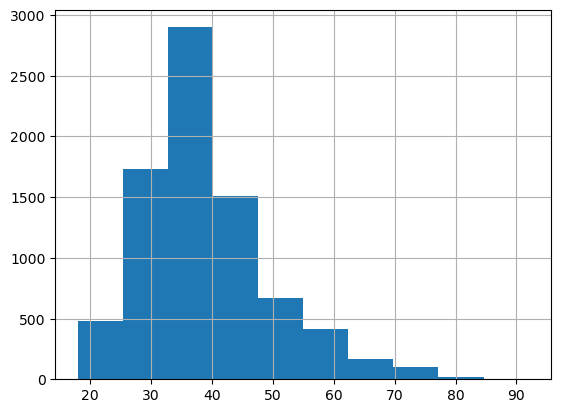

In [50]:
train_full['Age'].hist()


In [51]:
train_full['age_group'] = pd.qcut(train_full['Age'], 5)



In [52]:
# на своднике видно, что чем больше возраст, тем больше шанс что клиент уйдет
train_full.groupby('age_group')['Exited'].agg(['count', 'mean'])

/tmp/ipykernel_46690/3816946021.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_full.groupby('age_group')['Exited'].agg(['count', 'mean'])


,count,mean
age_group,,
"(17.999, 31.0]",1896,0.075422
"(31.0, 35.0]",1424,0.091994
"(35.0, 40.0]",1797,0.146912
"(40.0, 46.0]",1376,0.289971
"(46.0, 92.0]",1507,0.459854


    прежде чем добавлять переменную в модель, сделаю её не qcut, а cut и сделаю её вручнуую
    
    поотому что когда я буду рассчитыывать эту группу для теста, то не смогу применить кукат.
    не смогу смотреть на все записи в тесте что бы рассчитать для них группы.
    Это новые данные и каждая строчка должна обрабатываться отдельно.
    Надо увидедь одно наблюдение(одного клиента) и принять по нему решение
    
    И во вторых если сделать кукат на тесте, то там могут получитсья совершенно другие группы
    потому что там другая выборка
    
    и надо сохранить интервалы такие же, что и на трейне. И потом их уже применить к тесту
    
    
    
    Когда мы выбираем между cut и qcut при разбиении переменных на интервалы для обучения модели, важно учитывать несколько аспектов:

    Невозможность пересчёта квантилей на тестовых данных: При использовании qcut интервалы формируются на основе квантилей в тренировочной выборке (train), что означает зависимость от распределения данных. Если распределение данных в тестовой выборке (test) отличается, qcut может создать другие границы интервалов. Это нарушает основной принцип машинного обучения — применять те же самые правила, что и на тренировочных данных, к новым данным.

    Пример: Если в тренировочной выборке интервалы возраста составляют 18-30, 30-45, 45-60, то в тестовой выборке, где больше людей старшего возраста, qcut может задать интервалы 18-40, 40-55 и 55-90. Это может негативно сказаться на точности модели, поскольку она будет обучена на одном наборе интервалов, а применять придётся на другом.

    Тестовые данные обрабатываются по одному наблюдению: В процессе обучения модели мы располагаем всеми данными сразу, и qcut может использовать их для расчёта интервалов. Однако в реальной эксплуатации данные поступают по одному (например, данные о новом клиенте), и нет возможности пересчитывать квантильные границы каждый раз для каждого нового наблюдения. Нужно заранее зафиксировать интервалы, полученные на этапе обучения, и применять их к новым данным.

    Стабильные интервалы между train и test: Чтобы избежать того, что интервалы в тестовой выборке будут сильно отличаться от тех, что использовались на этапе обучения, лучше применять cut с заранее заданными границами. Это позволяет сохранить одинаковые интервалы как для тренировочных, так и для тестовых данных, что обеспечивает предсказуемость поведения модели.

    Пример: Если при использовании cut задать интервалы возраста 18-30, 30-45, 45-60, эти интервалы останутся такими же как в тренировочной, так и в тестовой выборке, что предотвратит потерю информации или ухудшение точности модели из-за изменившихся границ.

    Применение фиксированных интервалов: Используя cut, можно заранее определить интервалы, которые потом будут применяться ко всем новым наблюдениям. Это особенно важно, когда работа идёт с новыми данными, и нет возможности пересчитывать интервалы на лету, как это делает qcut.

    Вывод:
    Использование cut предпочтительнее, потому что:

    Интервалы остаются неизменными как для обучающих, так и для тестовых данных.
    qcut может создать другие интервалы для новых данных, что приведёт к непредсказуемым результатам и снижению точности модели.
    В реальных условиях данные обрабатываются по одному наблюдению, и пересчитывать квантильные интервалы при использовании qcut невозможно.
    Таким образом, cut обеспечивает стабильность и предсказуемость при работе с новыми данными.

    так же есть такая статья на стаковерфлоу
    https://stackoverflow.com/questions/37906210/applying-pandas-qcut-bins-to-new-data
    

In [53]:
# на выходе будет два массива, один с группой(0,1,2,3...) и разбиение по возрасту
pd.qcut(train_full['Age'], 5, retbins=True, labels=False)

(257     3
 3036    0
 4054    3
 3202    2
 1874    0
        ..
 94      0
 5637    3
 2489    3
 584     3
 2405    0
 Name: Age, Length: 8000, dtype: int64,
 array([18., 31., 35., 40., 46., 92.]))

In [54]:
# вручную. сейчас ничего не поменялось, но теперь можно это [0, 31, 35, 40, 46, float('inf')] применять к тесту
train_full['age_group'] = pd.cut(train_full['Age'],[0, 31, 35, 40, 46, float('inf')])


In [55]:
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean,age_group
257,4512,15568006,Ukaegbunam,634,France,Female,45,2,0.00,4,1,0,101039.53,1,0.999979,0.20375,"(40.0, 46.0]"
3036,4655,15593976,Swanson,578,Germany,Female,31,5,102088.68,4,0,0,187866.21,1,0.999966,0.20375,"(0.0, 31.0]"
4054,4404,15616859,Bonwick,602,Germany,Female,43,2,113641.49,4,1,0,115116.35,1,0.999954,0.20375,"(40.0, 46.0]"
3202,9412,15796115,Forbes,689,Germany,Female,40,4,78119.59,4,1,0,119259.34,1,0.999942,0.20375,"(35.0, 40.0]"
1874,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.999935,0.20375,"(0.0, 31.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,9749,15680201,Marcelo,627,Germany,Male,24,5,102773.20,2,1,0,56793.02,1,0.076050,0.20375,"(0.0, 31.0]"
5637,3350,15603465,Dunn,665,Germany,Female,45,5,155447.65,2,1,0,51871.95,1,0.076050,0.20375,"(40.0, 46.0]"
2489,7652,15776921,Geoghegan,431,Germany,Male,45,5,83624.55,2,0,0,36899.62,0,0.076050,0.20375,"(40.0, 46.0]"
584,7453,15636562,Muravyova,573,Spain,Male,44,8,0.00,2,0,0,62424.46,0,0.076049,0.20375,"(40.0, 46.0]"


In [56]:
# добавляю группировку в модель

model = train_full.groupby(['NumOfProducts', 'age_group'])['Exited'].mean().reset_index()

/tmp/ipykernel_46690/123307631.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = train_full.groupby(['NumOfProducts', 'age_group'])['Exited'].mean().reset_index()


In [57]:
model # модель теперь имеет две переменные

,NumOfProducts,age_group,Exited
0,1,"(0.0, 31.0]",0.106774
1,1,"(31.0, 35.0]",0.135908
2,1,"(35.0, 40.0]",0.198646
3,1,"(40.0, 46.0]",0.378873
4,1,"(46.0, inf]",0.542506
5,2,"(0.0, 31.0]",0.029293
6,2,"(31.0, 35.0]",0.031206
7,2,"(35.0, 40.0]",0.059977
8,2,"(40.0, 46.0]",0.106239
9,2,"(46.0, inf]",0.225869


In [58]:
model = model.rename({"Exited": "score_prod_age"}, axis=1)

In [59]:
# джойню уже по двум ключам
train_full = train_full.merge(model, how='left', on=['NumOfProducts', 'age_group'])

In [60]:
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean,age_group,score_prod_age
0,4512,15568006,Ukaegbunam,634,France,Female,45,2,0.00,4,1,0,101039.53,1,0.999979,0.20375,"(40.0, 46.0]",1.000000
1,4655,15593976,Swanson,578,Germany,Female,31,5,102088.68,4,0,0,187866.21,1,0.999966,0.20375,"(0.0, 31.0]",1.000000
2,4404,15616859,Bonwick,602,Germany,Female,43,2,113641.49,4,1,0,115116.35,1,0.999954,0.20375,"(40.0, 46.0]",1.000000
3,9412,15796115,Forbes,689,Germany,Female,40,4,78119.59,4,1,0,119259.34,1,0.999942,0.20375,"(35.0, 40.0]",1.000000
4,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.999935,0.20375,"(0.0, 31.0]",1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9749,15680201,Marcelo,627,Germany,Male,24,5,102773.20,2,1,0,56793.02,1,0.076050,0.20375,"(0.0, 31.0]",0.029293
7996,3350,15603465,Dunn,665,Germany,Female,45,5,155447.65,2,1,0,51871.95,1,0.076050,0.20375,"(40.0, 46.0]",0.106239
7997,7652,15776921,Geoghegan,431,Germany,Male,45,5,83624.55,2,0,0,36899.62,0,0.076050,0.20375,"(40.0, 46.0]",0.106239
7998,7453,15636562,Muravyova,573,Spain,Male,44,8,0.00,2,0,0,62424.46,0,0.076049,0.20375,"(40.0, 46.0]",0.106239


In [61]:
log_loss(train_full['Exited'], train_full['score_prod'])



0.4359717821616623

In [62]:
uplift(train_full, 'score_prod', 0.2)

1.9079754601226995

In [63]:
# улучшилось на 5 процентов
log_loss(train_full['Exited'], train_full['score_prod_age'])


0.3866695862492173

In [64]:
uplift(train_full, 'score_prod_age', 0.2)

2.702453987730061

In [65]:
# теперь сдеалю для теста, добавлю группировку по годам cut. и использую теже интервалы что и на трейне
test['age_group'] = pd.cut(test['Age'],[0, 31, 35, 40, 46, float('inf')])


In [66]:
test = test.merge(model, how='left', on=['NumOfProducts', 'age_group'])

In [67]:
log_loss(test['Exited'], test['score_prod'])



0.4338658337619006

In [68]:
uplift(test, 'score_prod', 0.2)

1.8427518427518426

In [69]:
log_loss(test['Exited'], test['score_prod_age'])


0.3870707514157596

In [70]:
uplift(test, 'score_prod_age', 0.2)

2.7518427518427515

# IsActiveMember добавление
    IsActiveMember phikсчитает что это следубщая во важности переменная

In [71]:
train_full['IsActiveMember'].value_counts() # переменная категориальная

IsActiveMember
1    4131
0    3869
Name: count, dtype: int64

In [72]:
# сводкник для активного 
# и видно что если 0(не активный) то доля убывших клиентво больше
train_full.groupby('IsActiveMember')['Exited'].agg(['count', 'mean'])

,count,mean
IsActiveMember,,
0,3869,0.267511
1,4131,0.144033


In [73]:
# добавляю группировку в модель
# появились NaN пока ничего не деалю
model = train_full.groupby(['NumOfProducts', 'age_group', 'IsActiveMember'], observed=False)['Exited'].mean().reset_index()
model = model.rename({"Exited": "score_prod_age_active"}, axis=1)
model

,NumOfProducts,age_group,IsActiveMember,score_prod_age_active
0,1,"(0.0, 31.0]",0,0.143885
1,1,"(0.0, 31.0]",1,0.072687
2,1,"(31.0, 35.0]",0,0.177650
3,1,"(31.0, 35.0]",1,0.094286
4,1,"(35.0, 40.0]",0,0.223714
5,1,"(35.0, 40.0]",1,0.173121
6,1,"(40.0, 46.0]",0,0.466146
7,1,"(40.0, 46.0]",1,0.276074
8,1,"(46.0, inf]",0,0.793103
9,1,"(46.0, inf]",1,0.334016


    добавляю в выборкии новую модель. джойню по трем уже переменным

In [74]:
train_full = train_full.merge(model, how='left', on=['NumOfProducts', 'age_group', 'IsActiveMember'])

In [75]:
test = test.merge(model, how='left', on=['NumOfProducts', 'age_group', 'IsActiveMember'])

In [76]:
train_full

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,score_mean,age_group,score_prod_age,score_prod_age_active
0,4512,15568006,Ukaegbunam,634,France,Female,45,2,0.00,4,1,0,101039.53,1,0.999979,0.20375,"(40.0, 46.0]",1.000000,1.000000
1,4655,15593976,Swanson,578,Germany,Female,31,5,102088.68,4,0,0,187866.21,1,0.999966,0.20375,"(0.0, 31.0]",1.000000,1.000000
2,4404,15616859,Bonwick,602,Germany,Female,43,2,113641.49,4,1,0,115116.35,1,0.999954,0.20375,"(40.0, 46.0]",1.000000,1.000000
3,9412,15796115,Forbes,689,Germany,Female,40,4,78119.59,4,1,0,119259.34,1,0.999942,0.20375,"(35.0, 40.0]",1.000000,1.000000
4,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.999935,0.20375,"(0.0, 31.0]",1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9749,15680201,Marcelo,627,Germany,Male,24,5,102773.20,2,1,0,56793.02,1,0.076050,0.20375,"(0.0, 31.0]",0.029293,0.033058
7996,3350,15603465,Dunn,665,Germany,Female,45,5,155447.65,2,1,0,51871.95,1,0.076050,0.20375,"(40.0, 46.0]",0.106239,0.144262
7997,7652,15776921,Geoghegan,431,Germany,Male,45,5,83624.55,2,0,0,36899.62,0,0.076050,0.20375,"(40.0, 46.0]",0.106239,0.144262
7998,7453,15636562,Muravyova,573,Spain,Male,44,8,0.00,2,0,0,62424.46,0,0.076049,0.20375,"(40.0, 46.0]",0.106239,0.144262


In [77]:
# что бы не вызывать каждый раз
def print_metrics(df, score):
    print(log_loss(df['Exited'], df[score]))
    print(uplift(df, score, 0.2))

In [78]:
print_metrics(df=train_full, score='score_prod_age')

0.3866695862492173
2.702453987730061


In [79]:
print_metrics(df=test, score='score_prod_age')

0.3870707514157596
2.7518427518427515


In [80]:
print_metrics(df=train_full, score='score_prod_age_active')

0.3655019751451003
2.861963190184049


In [81]:
print_metrics(df=test, score='score_prod_age_active')

0.3638472889481342
2.862407862407862


# Machine learning

    использую опять катбуст. но на этот раз катбусткласифайр
    использую теже колонки что использовал в человеческом обучении

In [82]:
from catboost import CatBoostClassifier

In [83]:
train_full.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'score_prod',
       'score_mean', 'age_group', 'score_prod_age', 'score_prod_age_active'],
      dtype='object')

In [84]:
# не будет списка категорильных фичей, так как все  фичи которые я взял, они числовые
X = ['NumOfProducts', 'Age', 'IsActiveMember']
y = ['Exited'] # таргет, целевая переменная

In [85]:
# создам словарь с параметрами, ччто бы удобней было менять и передавать в модель
params = {
    'verbose': 100, # что бы видеть пачками по 100
    'random_seed': 42  # что бы рандом был зафиксирован
}

In [86]:
model = CatBoostClassifier(**params)

In [87]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

Learning rate set to 0.04933
0:	learn: 0.6541260	test: 0.6538718	best: 0.6538718 (0)	total: 52ms	remaining: 51.9s
100:	learn: 0.3554450	test: 0.3428371	best: 0.3428371 (100)	total: 211ms	remaining: 1.88s
200:	learn: 0.3512469	test: 0.3417331	best: 0.3417117 (178)	total: 325ms	remaining: 1.29s
300:	learn: 0.3464561	test: 0.3433005	best: 0.3416354 (217)	total: 448ms	remaining: 1.04s
400:	learn: 0.3435327	test: 0.3449275	best: 0.3416354 (217)	total: 570ms	remaining: 851ms
500:	learn: 0.3415461	test: 0.3467565	best: 0.3416354 (217)	total: 690ms	remaining: 687ms
600:	learn: 0.3400642	test: 0.3485428	best: 0.3416354 (217)	total: 811ms	remaining: 538ms
700:	learn: 0.3388479	test: 0.3501575	best: 0.3416354 (217)	total: 931ms	remaining: 397ms
800:	learn: 0.3380663	test: 0.3521356	best: 0.3416354 (217)	total: 1.05s	remaining: 262ms
900:	learn: 0.3374401	test: 0.3534681	best: 0.3416354 (217)	total: 1.18s	remaining: 129ms
999:	learn: 0.3369346	test: 0.3547668	best: 0.3416354 (217)	total: 1.3s	rema

    лучшая итерация на 218 позиции. А надо что бы она была ближе к концу.
    
    Почему лучше, чтобы лучшая итерация была ближе к концу:
    Признак стабильного обучения: Если лучшая итерация находится ближе к концу, это означает, что модель продолжает учиться и улучшать свои результаты на протяжении всего времени обучения. Это говорит о том, что модель обучается устойчиво, и оптимизация всё ещё приносит пользу на более поздних этапах.

    Переобучение (overfitting): Когда лучшая итерация находится рано (например, на 217 шаге из 1000), это может быть индикатором того, что после этого момента модель начинает переобучаться. Она начинает "запоминать" обучающие данные, но перестает улучшаться на валидационном (тестовом) наборе. Это означает, что модель лучше всего предсказывает на ранних итерациях, а затем её качество начинает снижаться на валидации, что нежелательно.

    Знак того, что модель рано останавливается: Если лучшая итерация очень ранняя, это может означать, что ты можешь рассмотреть возможность применения меньшего количества итераций (или остановки модели раньше), чтобы избежать переобучения. В идеале, если лучшая итерация была бы ближе к концу, это было бы показателем того, что модель эффективно использовала всю мощность доступных итераций.
    
    
    Регуляризация: Чтобы уменьшить переобучение, можно попробовать использовать методы регуляризации или уменьшить скорость обучения (learning rate), чтобы модель училась более плавно.

In [88]:
# создам словарь с параметрами, ччто бы удобней было менять и передавать в модель
params = {
    'verbose': 100, # что бы видеть пачками по 100
    'random_seed': 42,  # что бы рандом был зафиксирован
    'learning_rate': 0.01 # что бы лучшая итерация была ближе к концу
}

In [89]:
model = CatBoostClassifier(**params)

In [90]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))


0:	learn: 0.6849803	test: 0.6849389	best: 0.6849389 (0)	total: 3.13ms	remaining: 3.12s
100:	learn: 0.3991169	test: 0.3930537	best: 0.3930537 (100)	total: 174ms	remaining: 1.55s
200:	learn: 0.3659581	test: 0.3563817	best: 0.3563817 (200)	total: 292ms	remaining: 1.16s
300:	learn: 0.3589224	test: 0.3476566	best: 0.3476566 (300)	total: 416ms	remaining: 966ms
400:	learn: 0.3565171	test: 0.3446648	best: 0.3446648 (400)	total: 540ms	remaining: 806ms
500:	learn: 0.3553274	test: 0.3433005	best: 0.3432984 (498)	total: 661ms	remaining: 658ms
600:	learn: 0.3544987	test: 0.3425379	best: 0.3425379 (600)	total: 792ms	remaining: 526ms
700:	learn: 0.3539638	test: 0.3421168	best: 0.3421135 (699)	total: 917ms	remaining: 391ms
800:	learn: 0.3532817	test: 0.3419139	best: 0.3419139 (800)	total: 1.04s	remaining: 258ms
900:	learn: 0.3524351	test: 0.3416923	best: 0.3416923 (900)	total: 1.16s	remaining: 127ms
999:	learn: 0.3513546	test: 0.3417688	best: 0.3416551 (927)	total: 1.28s	remaining: 0us

bestTest = 0.3

    для подсчета качества на тесте надо сделать предикт
    
    Predict (предикт) — это процесс, в котором модель использует уже обученные параметры для предсказания целевых значений на новых данных, которые она ранее не видела (например, на тестовой выборке).
    
    после того, как модель была обучена на тренировочной выборке, нужно использовать её для предсказания результатов на тестовых данных. Именно с помощью этих предсказанных значений можно оценить качество модели, сравнив их с реальными значениями на тестовой выборке.
    
    Predict — это процесс предсказания модели. После того, как модель обучена, её можно использовать для предсказания целевого значения на новых данных. Для этого обычно используется метод .predict(), который есть у большинства моделей машинного обучения.

In [91]:
# здесь пришли классы , то есть конечное решение модели о том, 
# к какому классу относится каждое наблюдение (например, 0 — клиент не ушел, 1 — клиент ушел). 
# а нам нужны скоры
model.predict(test[X])

array([0, 0, 0, ..., 0, 0, 0])

In [92]:
# что бы сделать скоры делаю predict_proba. первый столбец на класс 0, второй столбец на класс 1
model.predict_proba(test[X])

array([[0.87273278, 0.12726722],
       [0.83992875, 0.16007125],
       [0.76421314, 0.23578686],
       ...,
       [0.85243229, 0.14756771],
       [0.96002386, 0.03997614],
       [0.95396298, 0.04603702]])

In [93]:
# нам нужен скор на отток. второй столбце
model.predict_proba(test[X])[:,1]

array([0.12726722, 0.16007125, 0.23578686, ..., 0.14756771, 0.03997614,
       0.04603702])

In [94]:
test['score_cat_prod_age_active'] = model.predict_proba(test[X])[:,1]

In [95]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,age_group,score_prod_age,score_prod_age_active,score_cat_prod_age_active
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,0.274995,"(0.0, 31.0]",0.106774,0.143885,0.127267
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,0.274419,"(31.0, 35.0]",0.135908,0.177650,0.160071
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,0.274637,"(35.0, 40.0]",0.198646,0.223714,0.235787
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,0.274771,"(31.0, 35.0]",0.135908,0.177650,0.160071
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,0.275213,"(31.0, 35.0]",0.135908,0.094286,0.102859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,0.076392,"(46.0, inf]",0.225869,0.134048,0.052185
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,0.274413,"(35.0, 40.0]",0.198646,0.173121,0.127713
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,0.076980,"(40.0, 46.0]",0.106239,0.144262,0.147568
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,0.076992,"(35.0, 40.0]",0.059977,0.042353,0.039976


In [96]:
test['score_cat_prod_age_active'].nunique() # скоры не уникальные

254

In [97]:
len(test)

2000

In [98]:
print_metrics(df=test, score='score_prod_age_active') # то что после человеческого обучения

0.3638472889481342
2.862407862407862


In [100]:
print_metrics(df=test, score='score_prod_age_active')

0.3638472889481342
2.862407862407862


# Обучение на всех фичах
    RowNumber не даст какого то смысла к модели
    
    CustomerId тоже поидее не нужен, но иногда  он может быть каким то порядковым номером клиента. типа будет каким то индикатором, того когда клиент присоеденился... вдруг это тот случай
    
    Surname тоже ничего не даст
    
    Exited это игрек
    
    затем надо взять категориальные фичи. для этого посмотрю на сам датафрейм
    Geography and Gender

In [112]:
# если кат фичей много. можно еще так их посмотреть. большинство из них будет категориальными
train.select_dtypes(include='object').head()

,Surname,Geography,Gender
6851,Cantamessa,Germany,Female
7026,Horton,France,Female
5705,Doherty,Germany,Male
9058,Moran,Spain,Female
9415,Hunt,Germany,Female


In [101]:
train.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [105]:
train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0
5705,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0
9058,9059,15802560,Moran,470,Spain,Female,48,6,140576.11,1,1,1,116971.05,0
9415,9416,15750407,Hunt,768,Germany,Female,43,2,129264.05,2,0,0,19150.14,0


In [109]:
cat_features = ['Gender', 'Geography'] 

X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

y = ['Exited']

    ччто бы каждый раз не писать model.fit(train[X], train[y], eval_set=(val[X], val[y]))
    можно использовать Pool из кетбуст
    https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview (тут поискать как пользоваться)
    

In [113]:

from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [118]:
# создам словарь с параметрами, ччто бы удобней было менять и передавать в модель
params = {
    'verbose': 100, # что бы видеть пачками по 100
    'random_seed': 42,  # что бы рандом был зафиксирован
    'learning_rate': 0.01 # что бы лучшая итерация была ближе к концу
}

model = CatBoostClassifier(**params)

In [119]:
# model.fit(train[X], train[y], eval_set=(val[X], val[y])) # так уже не делаю. так как использовал пул
model.fit(train_data, eval_set=valid_data)


0:	learn: 0.6848575	test: 0.6849145	best: 0.6849145 (0)	total: 4.94ms	remaining: 4.94s
100:	learn: 0.3908412	test: 0.3894043	best: 0.3894043 (100)	total: 259ms	remaining: 2.3s
200:	learn: 0.3457312	test: 0.3445503	best: 0.3445503 (200)	total: 530ms	remaining: 2.11s
300:	learn: 0.3288071	test: 0.3307084	best: 0.3307084 (300)	total: 807ms	remaining: 1.87s
400:	learn: 0.3192987	test: 0.3252459	best: 0.3252459 (400)	total: 1.09s	remaining: 1.62s
500:	learn: 0.3120470	test: 0.3221057	best: 0.3221057 (500)	total: 1.37s	remaining: 1.36s
600:	learn: 0.3054735	test: 0.3204300	best: 0.3204300 (600)	total: 1.65s	remaining: 1.1s
700:	learn: 0.2997053	test: 0.3192377	best: 0.3192377 (700)	total: 1.94s	remaining: 828ms
800:	learn: 0.2946934	test: 0.3188206	best: 0.3187917 (794)	total: 2.22s	remaining: 552ms
900:	learn: 0.2890177	test: 0.3185731	best: 0.3185731 (900)	total: 2.5s	remaining: 275ms
999:	learn: 0.2831978	test: 0.3186396	best: 0.3185004 (978)	total: 2.79s	remaining: 0us

bestTest = 0.3185

In [120]:
test['score_cat_prod_age_active_all_features'] = model.predict_proba(test[X])[:,1]

In [122]:
test.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,score_prod,age_group,score_prod_age,score_prod_age_active,score_cat_prod_age_active,score_cat_prod_age_active_all_features
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,0.274995,"(0.0, 31.0]",0.106774,0.143885,0.127267,0.131844
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,0.274419,"(31.0, 35.0]",0.135908,0.177650,0.160071,0.074020


In [123]:
print_metrics(df=test, score='score_prod_age_active')

0.3638472889481342
2.862407862407862


In [124]:
print_metrics(df=test, score='score_cat_prod_age_active_all_features')

0.3296082204006806
3.1449631449631448


# model interpitation

# важность фичей
    что важно для кетбуста

In [125]:
model.get_feature_importance(prettified=True) # что важно по мнению кетбуст

,Feature Id,Importances
0,NumOfProducts,27.408724
1,Age,21.567747
2,Balance,11.455919
3,Geography,10.011145
4,IsActiveMember,7.420335
5,EstimatedSalary,5.163513
6,CustomerId,4.965796
7,CreditScore,4.482999
8,Tenure,3.637201
9,Gender,3.089379


In [127]:
phik_overview['Exited'].sort_values(ascending=False) # что важно по мнению phik

Exited             1.000000
NumOfProducts      0.564969
Age                0.498241
IsActiveMember     0.237244
Balance            0.167823
Gender             0.165231
CreditScore        0.123343
Geography          0.104047
CustomerId         0.035798
Tenure             0.033611
RowNumber          0.000000
Surname            0.000000
HasCrCard          0.000000
EstimatedSalary    0.000000
Name: Exited, dtype: float64

# Shap
    как двигает модель каждая фича. вверх или вниз
        библиотека, которая позволяет считать вклад каждой фичи в предсказании


In [129]:
# ! pip install shap


In [130]:
# нужно так испортировать для каждой ячейке ессли работаю в колаб 
import shap
shap.initjs()


In [132]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(test[X])

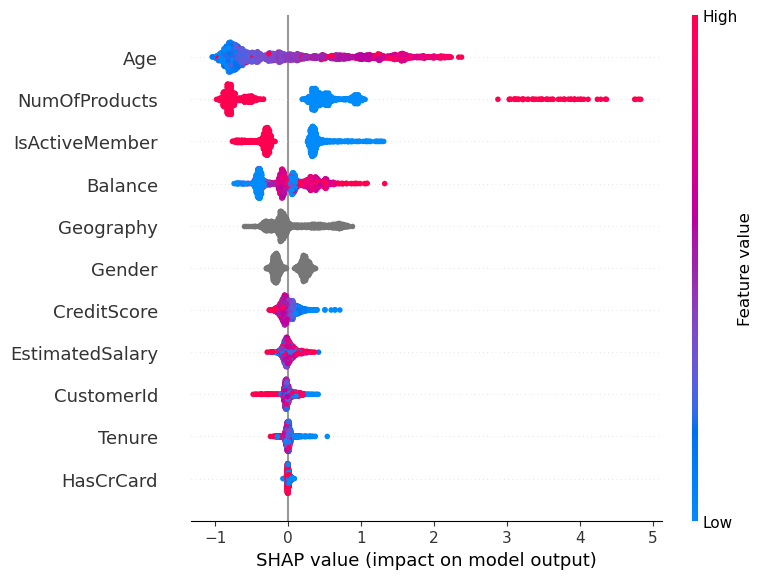

In [133]:
# summary plot
shap.summary_plot(shap_values.values, test[X])

In [135]:
train_full.groupby('NumOfProducts')['Exited'].agg(['count', 'mean'])

,count,mean
NumOfProducts,,
1,4060,0.275369
2,3673,0.077049
3,219,0.826484
4,48,1.000000


    теперь посмотрю на каждую фичю по отдельности. с помощью dependense plot
    можно посомтртеь по каждой фиче в ручную. типа писать вызов депенденс плот каждый раз
    а можно циклом все это сделать

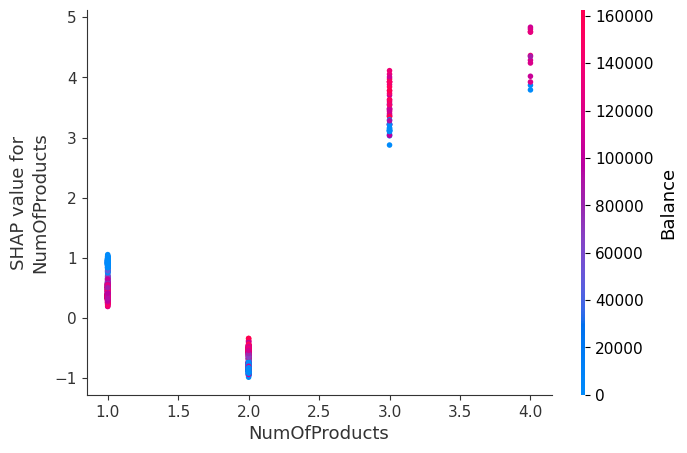

In [137]:
shap.dependence_plot("NumOfProducts", shap_values.values, test[X])

In [138]:
model.get_feature_importance(prettified=True) 

,Feature Id,Importances
0,NumOfProducts,27.408724
1,Age,21.567747
2,Balance,11.455919
3,Geography,10.011145
4,IsActiveMember,7.420335
5,EstimatedSalary,5.163513
6,CustomerId,4.965796
7,CreditScore,4.482999
8,Tenure,3.637201
9,Gender,3.089379


In [141]:
features = model.get_feature_importance(prettified=True)['Feature Id'].values

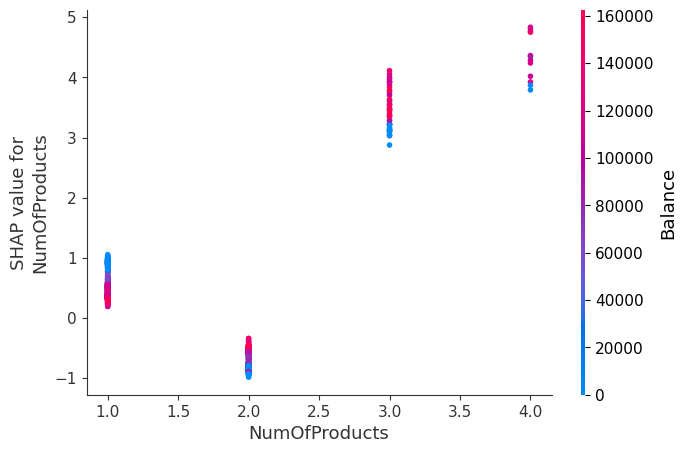

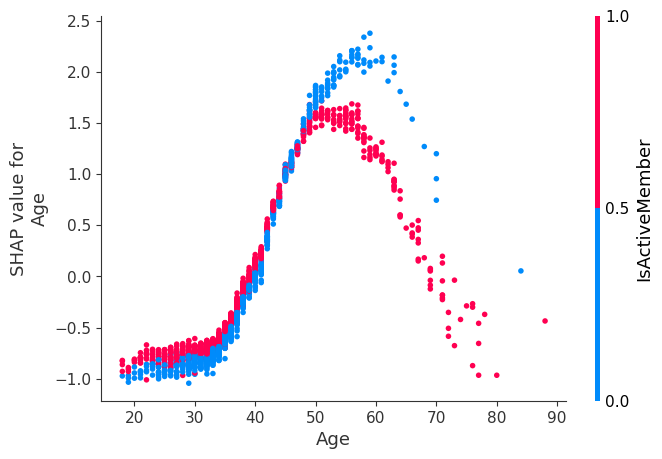

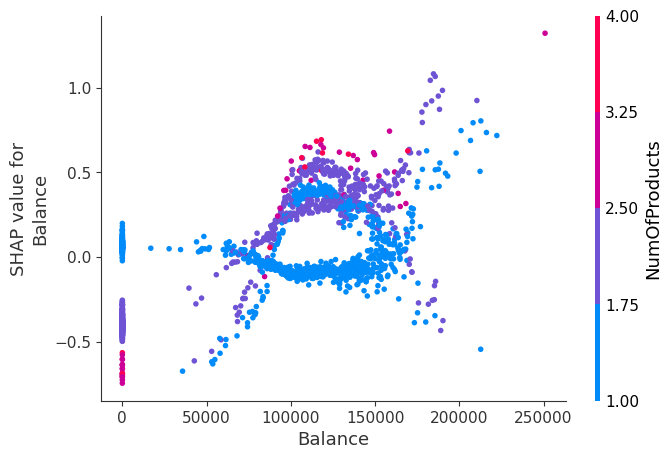

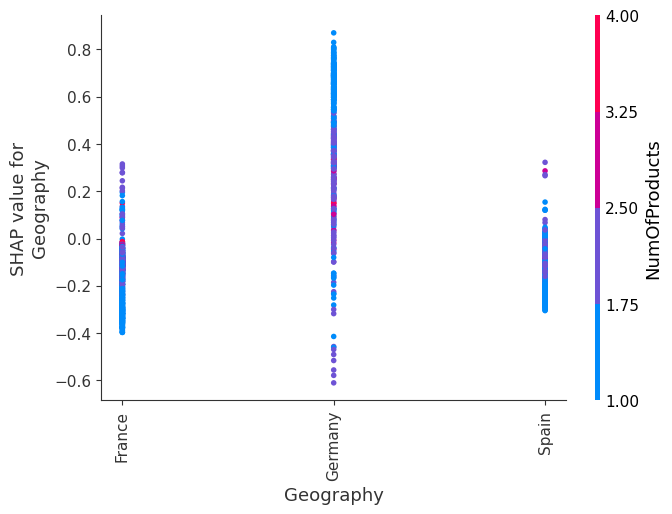

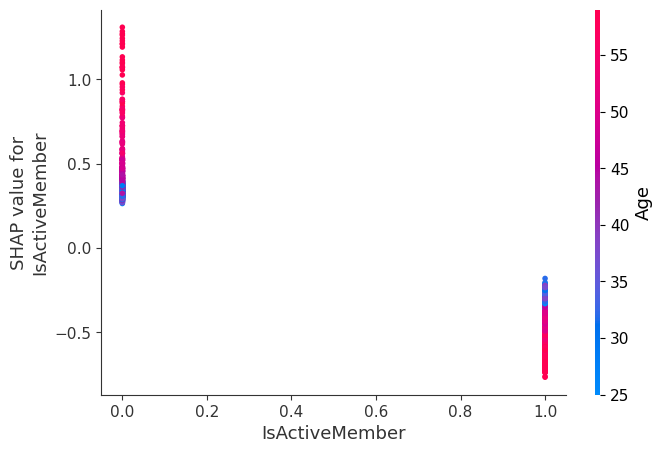

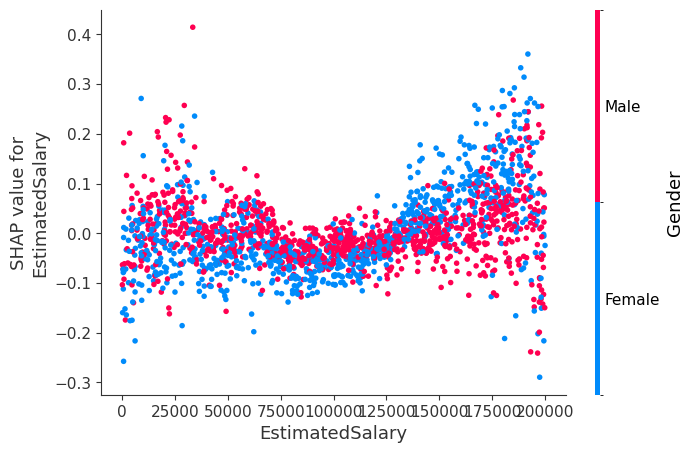

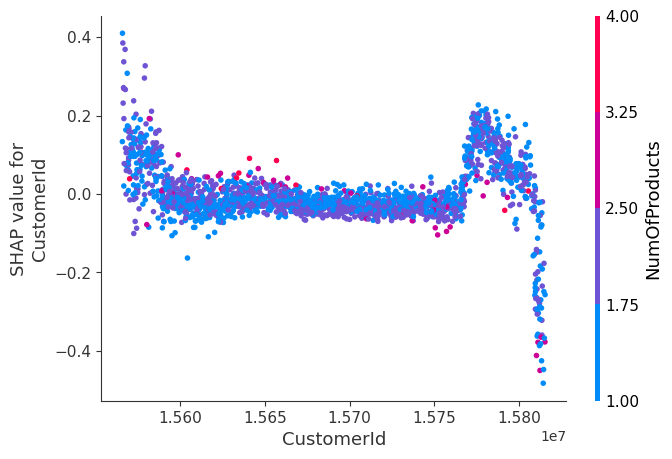

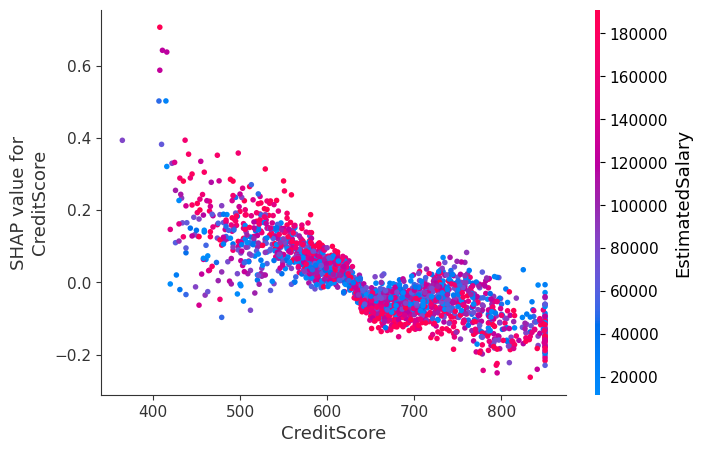

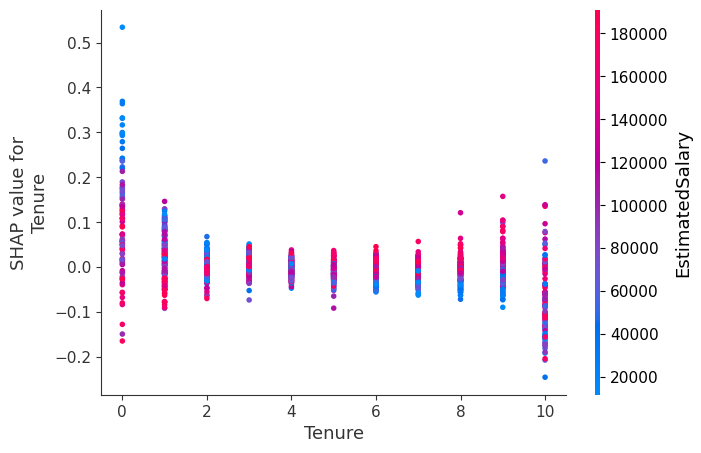

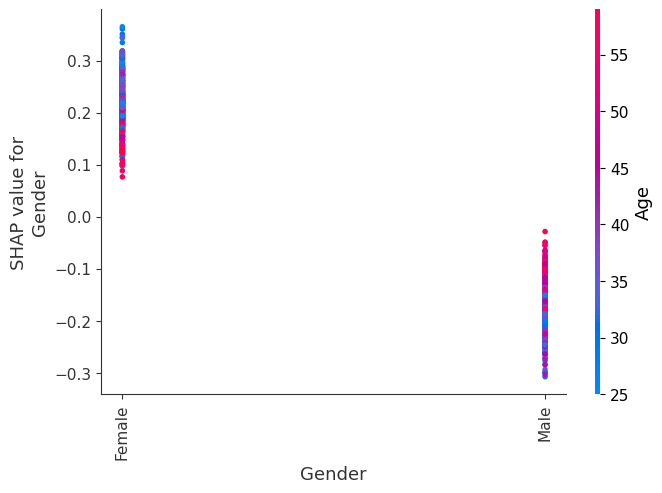

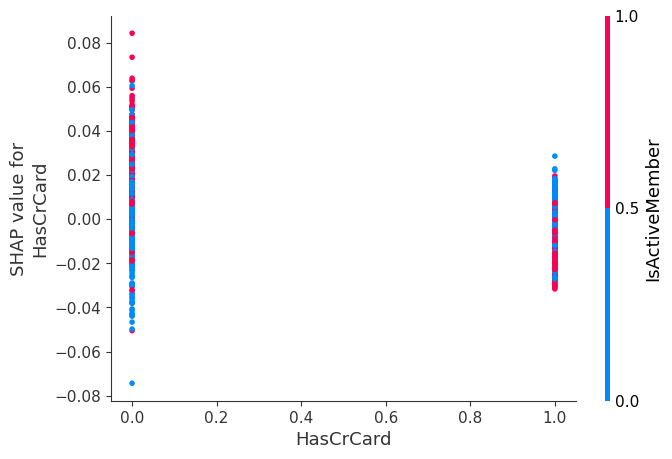

In [150]:

for feature in features:
    shap.dependence_plot(feature, shap_values.values, test[X])

    проанализировтаь ошибку так же как в делали в регрессии. посчитать разницу между таргетом и предиктом
    
    
    классификация от регрессии технические не отличается
    под капотом катбуст предсказывает регрессию, и в конце вот этта непрерывная от минус бескончности до плюс бесконечности перегоняется в некий норм скор, который идет от 0 до 1
    
    
    В задачах классификации модели, такие как CatBoost, под капотом предсказывают непрерывные значения, как в регрессии. Эти значения могут быть от минус до плюс бесконечности. В конце такие "сырые" предсказания преобразуются в вероятность с помощью СИГМОИДАЛЬНОЙ функции для бинарной классификации или softmax для многоклассовой классификации. Это позволяет получить вероятность принадлежности к классу, которую модель использует для принятия решения о финальном предсказании (класс 0 или 1).
    
    Технически классификация и регрессия не сильно отличаются:
    Регрессия: задача предсказания непрерывных значений. Например, предсказание цены дома, где модель пытается вычислить конкретное число.
    Классификация: задача предсказания категорий (например, ушел клиент или нет — бинарная классификация). Модель предсказывает вероятность того, что объект принадлежит к одному из классов.
    Однако под капотом многие модели машинного обучения, включая CatBoost, работают с регрессией на промежуточных этапах, даже если задача — классификация.

In [152]:
# то что делает кетбуст под капотом. как задача регрессии
model.predict(test[X], prediction_type='RawFormulaVal')

array([-1.88475323, -2.52652396, -1.47044046, ..., -1.73922605,
       -2.68750234, -2.93959577])

<Axes: >

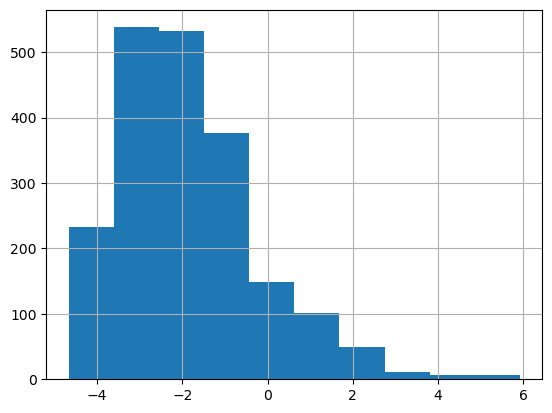

In [153]:
pd.Series(model.predict(test[X], prediction_type='RawFormulaVal')).hist()

In [154]:
import math

# функция сигмойда кастомная, под капотом кетбуста такая же. она перегоняет все в то что будет как в предикте
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [155]:
pd.Series(model.predict(test[X], prediction_type='RawFormulaVal')).apply(sigmoid)

0       0.131844
1       0.074020
2       0.186876
3       0.087403
4       0.056658
          ...   
1995    0.026803
1996    0.084712
1997    0.149411
1998    0.063715
1999    0.050231
Length: 2000, dtype: float64

In [156]:
model.predict_proba(test[X])

array([[0.86815614, 0.13184386],
       [0.92598046, 0.07401954],
       [0.81312433, 0.18687567],
       ...,
       [0.85058873, 0.14941127],
       [0.93628515, 0.06371485],
       [0.94976945, 0.05023055]])